In [1]:

!pip install mtcnn
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import cv2
from PIL import Image
import requests
from io import BytesIO
from matplotlib import pyplot as plt
import os

from mtcnn.mtcnn import *

pd.options.display.max_colwidth = 100

img_path = '/content/tmp/'

np.random.seed(0)

     |████████████████████████████████| 2.3MB 3.5MB/s 
  Created wheel for mtcnn: filename=mtcnn-0.0.9-cp36-none-any.whl size=2257692 sha256=5085d48c0d0f6ca742a808e3b3672261a75fe7f2f85d1fa33ad9791d2966a5b6
  Stored in directory: /root/.cache/pip/wheels/85/81/65/6363fa5aafd7a155c896591e0c7c6e27b69642aa82b9cbf076
Successfully built mtcnn


# Load Data

In [2]:
from google.colab import files
uploaded = files.upload()
# Run this cell, and upload JSON data file using the prompt that appears below.
# If prompt doesn't appear or dosn't work, reset kernel/runtime.

Saving Face_Recognition.json to Face_Recognition.json


In [73]:
data = pd.read_json(BytesIO(uploaded['Face_Recognition.json']), lines=True)
#img=cv2.imread('')
data.style.set_properties(subset=['content'],**{'width': '800px'})
data.head()


,annotation,content,extras,metadata
0,"[{'label': ['Emotion_Happy', 'Age_below20', 'E_White', 'G_Male'], 'notes': '', 'points': [{'x': ...",http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb06477f4cb0164895548a600a3/66127d05-93e...,NaN,"{'first_done_at': 1531657992000, 'last_updated_at': 1531657992000, 'sec_taken': 23, 'last_update..."
1,"[{'label': ['Emotion_Happy', 'Age_20_30', 'E_Hispanic', 'G_ Female'], 'notes': '', 'points': [{'...",http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb06477f4cb0164895548a600a3/e3f39fd4-888...,NaN,"{'first_done_at': 1531720527000, 'last_updated_at': 1531720527000, 'sec_taken': 32, 'last_update..."
2,"[{'label': ['Emotion_Neutral', 'Age_20_30', 'E_Asian', 'G_ Female'], 'notes': '', 'points': [{'x...",http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb06477f4cb0164895548a600a3/70f5af4f-f97...,NaN,"{'first_done_at': 1531657879000, 'last_updated_at': 1531657879000, 'sec_taken': 53, 'last_update..."
3,"[{'label': ['Not_Face'], 'notes': '', 'points': [{'x': 0.089709762532981, 'y': 0.36953455571227}...",http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb06477f4cb0164895548a600a3/2f86e23f-539...,NaN,"{'first_done_at': 1531585322000, 'last_updated_at': 1531585322000, 'sec_taken': 344, 'last_updat..."
4,"[{'label': ['Emotion_Neutral', 'Age_30_40', 'E_Black', 'G_Male'], 'notes': '', 'points': [{'x': ...",http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb06477f4cb0164895548a600a3/07e7620b-09d...,NaN,"{'first_done_at': 1531380495000, 'last_updated_at': 1531380495000, 'sec_taken': 2990, 'last_upda..."


In [74]:
data['metadata'][0]

{'first_done_at': 1531657992000,
 'last_updated_at': 1531657992000,
 'last_updated_by': 'HWbICv9u4uSnWrU830DjuF7FfMK2',
 'sec_taken': 23}

Metadata column does not provide any information useful for face recognition. The timings of taking image are irrelevant for this task. 

In [75]:
data['extras'].value_counts()

Series([], Name: extras, dtype: int64)

We see that extras column has no value. On opening the JSON file as text we find that all the values are null. Hence we can remove this column.

In [76]:
data['annotation'][0]

[{'imageHeight': 741,
  'imageWidth': 1300,
  'label': ['Emotion_Happy', 'Age_below20', 'E_White', 'G_Male'],
  'notes': '',
  'points': [{'x': 0.198768689533861, 'y': 0.231481481481481},
   {'x': 0.324538258575197, 'y': 0.45987654320987603}]},
 {'imageHeight': 741,
  'imageWidth': 1300,
  'label': ['Emotion_Happy', 'Age_20_30', 'E_White', 'G_ Female'],
  'notes': '',
  'points': [{'x': 0.6024626209322771, 'y': 0.160493827160493},
   {'x': 0.7361477572559361, 'y': 0.368827160493827}]}]

Annotation provides many information about faces in the image such as height and width of image, normalized coordinates of bounding box of faces in the image and their characterstics. We do not have to predict the gender of people so we can remove the gender attribute.

## Download all the images to disk and load in a list. 


In [77]:
# Make a temporary directory to store downloaded images
!mkdir /content/tmp

mkdir: cannot create directory ‘/content/tmp’: File exists


In [0]:
from io import StringIO, BytesIO
import urllib, urllib3
imgs = []
imgs_names = []
errorUrls = [] # To store the URLs of images whose download failed.
http = urllib3.PoolManager()
for url in data['content']:
    try:
        name = url.split('/')[-1]
        #print(ext)
        urllib.request.urlretrieve(url, img_path+name)
        # Store image as filename:data name-value pair.
        imgs.append(plt.imread(img_path+name, 0))
        imgs_names.append(name)
    except OSError as e:
        print('Error downloading',url)
        print(e)
        errorUrls.append(url)
    #except ValueError:
        #print(url)
      
# If AssertionError is raised, all files were not downloaded correctly.
assert len(os.listdir('/content/tmp')) == len(data['annotation'])

In [79]:
errorUrls # If the list is empty, then all the images were successfully loaded

[]

## Visualize image

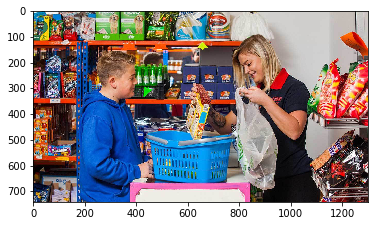

In [80]:
plt.imshow(imgs[0])

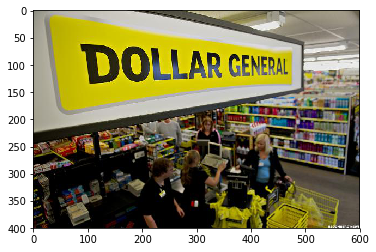

In [81]:
plt.imshow(imgs[66])

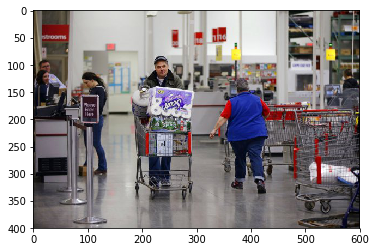

In [82]:
plt.imshow(imgs[73])

We find that images have following properties-
<ul>
  <li>Different resolutions.</li>
  <li>Multiple faces</li>
  <li>People facing front, sideways or turned backwards</li>
</ul>

There are also few images which also have alpha channel such as shown below.

In [83]:
imgs[imgs_names.index('98635f62-38b0-4ab1-be06-f1ece729d49d___clothesandpeople.gif')].shape

(195, 293, 4)

In [0]:
def get_faces_labels(annotations, imgs):
  data['annotation'][9][0]['label'][0]='Emotion_Neutral'
  annotations=data['annotation']
  temp_faces=[]
  count_idx=0
  img_dim=(100,100)
  features={'Emotion':[],'Age':[],'E':[],'G':[]}
  for annot in annotations:
    for face in annot:
      height = face['imageHeight']
      width=  face['imageWidth']
      x_min = int(face['points'][0]['x']*width)
      y_min = int(face['points'][0]['y']*height)
      x_max = int(face['points'][1]['x']*width)
      y_max = int(face['points'][1]['y']*height)
      img = imgs[count_idx][y_min:y_max,x_min:x_max]
      if img.shape[0]:
        img = cv2.resize(img,img_dim)
      else:
        img=np.zeros((100,100,3))
      img=img/255
      features['Emotion'].append('NA')
      features['Age'].append('NA')
      features['E'].append('NA')
      features['G'].append('NA')
      for x in face['label']:
        feat_type = x.split('_')[0] 
        if(feat_type!='Not'):
          features[feat_type][-1]=(x[len(feat_type)+1:])
        else:
          features['Emotion'][-1]=x
      temp_faces.append(img)
      #if img.shape == (100, 100, 4):
      #    print('>>', imgs_names[count_idx])
    count_idx+=1

  faces=[]
  for i in temp_faces:
    if i.shape[2]==4:
      faces.append(np.asarray(i[:,:,:3]))
    else:
      faces.append(np.asarray(i))

  #faces = np.vstack(faces).reshape(len(faces),100,100,3)
  ######
  emotions = pd.DataFrame({'faces':faces,'emotion':features['Emotion']})
  ages = pd.DataFrame({'faces':faces,'age':features['Age']})
  ethinicities = pd.DataFrame({'faces':faces,'ethinicity':features['E']})
  genders = pd.DataFrame({'faces':faces,'gender':features['G']})
  
  emotion_data = emotions[emotions.emotion!='NA']
  age_data = ages[ages.age!='NA']
  ethinicity_data = ethinicities[ethinicities.ethinicity!='NA']
  gender_data = genders[genders.gender!='NA']
  
  return faces, emotion_data, ethinicity_data, age_data

In [85]:

faces, emotion_data, ethinicity_data, age_data = get_faces_labels(data['annotation'], imgs)
print('emotion : {}'.format(emotion_data.shape))
print('age : {}'.format(age_data.shape))
print('ethinicity : {}'.format(ethinicity_data.shape))
#print('gender : {}'.format(gender_data.shape))


emotion : (350, 2)
age : (201, 2)
ethinicity : (198, 2)


In [86]:
faces[0].dtype

dtype('float64')

In [87]:
emotion_data.head()

,faces,emotion
0,"[[[0.3137254901960784, 0.2, 0.1843137254901961], [0.20784313725490197, 0.10588235294117647, 0.09...",Happy
1,"[[[0.8705882352941177, 0.26666666666666666, 0.10588235294117647], [0.807843137254902, 0.31764705...",Happy
2,"[[[0.7725490196078432, 0.5725490196078431, 0.4980392156862745], [0.7764705882352941, 0.576470588...",Happy
3,"[[[0.7647058823529411, 0.7019607843137254, 0.6392156862745098], [0.7372549019607844, 0.674509803...",Happy
4,"[[[0.45098039215686275, 0.5529411764705883, 0.06274509803921569], [0.42745098039215684, 0.537254...",Happy


In [88]:
# List of emotions
emotion_list=list(set(emotion_data['emotion'])) 
#age_list=list(set(age_data['age']))

# List of ethinicities
e_list=list(set(ethinicity_data['ethinicity']))

# List of age categories
age_list=list(set(age_data['age']))

print(emotion_list)

['Sad', 'Not_Face', 'Neutral', 'Angry', 'Happy']


In [89]:
# Map each emotion to an integer 0,1,2,...
emotion_map={emotion_list[x]:x for x in range(len(emotion_list))}
#age_map={age_list[x]:x for x in range(len(age_list))}

# Map each ethinicty to an integer 0,1,2,...
e_map={e_list[x]:x for x in range(len(e_list))}

# Map each age group to an integer 0,1,2,...
age_map={age_list[x]:x for x in range(len(age_list))}

print(emotion_map)

{'Sad': 0, 'Not_Face': 1, 'Neutral': 2, 'Angry': 3, 'Happy': 4}


In [0]:
emotion_data.replace({'emotion':emotion_map},inplace=True)
age_data.replace({'age':age_map},inplace=True)
ethinicity_data.replace({'ethinicity':e_map},inplace=True)
#gender_data.replace({'gender':g_map},inplace=True)
reverse_emotion_map={i:k for k,i in emotion_map.items()}
reverse_age_map={i:k for k,i in age_map.items()}
reverse_e_map={i:k for k,i in e_map.items()}
#reverse_g_map={i:k for k,i in g_map.items()}
word_to_num={'emotion':emotion_map, 'ethinicity':e_map,'age':age_map}
num_to_word={'emotion':reverse_emotion_map, 'ethinicity':reverse_e_map,'age':reverse_age_map}
  

In [91]:
dims = dict()
for f in faces:
    if f.shape in dims:
        dims[f.shape] += 1
    else:
        dims[f.shape] = 1
dims

{(100, 100, 3): 351}

# Model Development

In [0]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [0]:
em_train, em_test = train_test_split(emotion_data, test_size=0.3)
age_train, age_test = train_test_split(age_data, test_size=0.3)
eth_train, eth_test = train_test_split(ethinicity_data, test_size=0.3)

In [94]:
em_x_train = np.asarray(list(em_train['faces']))
em_y_train = to_categorical(em_train['emotion'])
em_x_test = np.asarray(list(em_test['faces']))
em_y_test = to_categorical(em_test['emotion'])

eth_x_train = np.asarray(list(eth_train['faces']))
eth_y_train = to_categorical(eth_train['ethinicity'])
eth_x_test = np.asarray(list(eth_test['faces']))
eth_y_test = to_categorical(eth_test['ethinicity'])

age_x_train = np.asarray(list(age_train['faces']))
age_y_train = to_categorical(age_train['age'])
age_x_test = np.asarray(list(age_test['faces']))
age_y_test = to_categorical(age_test['age'])
#x2 = np.vstack(x2).reshape(len(x2),100,100,3)
print(em_x_train.shape, em_x_test.shape)
print(eth_x_train.shape, eth_x_test.shape)
print(age_x_train.shape, age_x_test.shape)

(245, 100, 100, 3) (105, 100, 100, 3)
(138, 100, 100, 3) (60, 100, 100, 3)
(140, 100, 100, 3) (61, 100, 100, 3)


In [95]:
emotion_model = keras.models.Sequential()
emotion_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100,100,3)))
emotion_model.add(layers.MaxPooling2D((2, 2)))
emotion_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
emotion_model.add(layers.MaxPooling2D((2, 2)))
emotion_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
emotion_model.add(layers.MaxPooling2D((2, 2)))
emotion_model.add(layers.Flatten())
emotion_model.add(layers.Dense(64,activation='relu'))
emotion_model.add(layers.Dropout(0.3))
emotion_model.add(layers.Dense(32,activation='relu'))
emotion_model.add(layers.Dropout(0.4))
emotion_model.add(layers.Dense(len(emotion_list),activation='softmax'))
emotion_model.summary()          

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6400)             

In [96]:
age_model = keras.models.Sequential()
age_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100,100,3)))
age_model.add(layers.MaxPooling2D((2, 2)))
age_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
age_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
age_model.add(layers.MaxPooling2D((2, 2)))
age_model.add(layers.Flatten())
age_model.add(layers.Dense(64,activation='relu'))
age_model.add(layers.Dropout(0.3))
age_model.add(layers.Dense(32,activation='relu'))
age_model.add(layers.Dropout(0.3))
age_model.add(layers.Dense(len(age_list),activation='softmax'))
age_model.summary()      

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 45, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)               

In [97]:
ethinicity_model = keras.models.Sequential()
ethinicity_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100,100,3)))
ethinicity_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
ethinicity_model.add(layers.MaxPooling2D((2, 2)))
ethinicity_model.add(layers.Flatten())
ethinicity_model.add(layers.Dropout(0.2))
ethinicity_model.add(layers.Dense(128,activation='relu'))
ethinicity_model.add(layers.Dense(64,activation='relu'))
ethinicity_model.add(layers.Dropout(0.2))
ethinicity_model.add(layers.Dense(len(e_list),activation='softmax'))
ethinicity_model.summary()      

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 147456)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 147456)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               18874496  
_________________________________________________________________
dense_19 (Dense)             (None, 64)               

In [98]:
ethinicity_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(lr=0.0050),metrics=['acc'])
ethinicity_model.fit(eth_x_train,eth_y_train,epochs=30,batch_size=30)

Epoch 1/30
138/138 [==============================] - 6s 42ms/sample - loss: 30.9801 - acc: 0.2899
Epoch 2/30
138/138 [==============================] - 6s 40ms/sample - loss: 1.7171 - acc: 0.4928
Epoch 3/30
138/138 [==============================] - 6s 40ms/sample - loss: 1.6874 - acc: 0.3768
Epoch 4/30
138/138 [==============================] - 6s 40ms/sample - loss: 1.6447 - acc: 0.5145
Epoch 5/30
138/138 [==============================] - 6s 41ms/sample - loss: 1.4654 - acc: 0.3116
Epoch 6/30
138/138 [==============================] - 6s 40ms/sample - loss: 1.4547 - acc: 0.4710
Epoch 7/30
138/138 [==============================] - 5s 40ms/sample - loss: 1.4881 - acc: 0.4928
Epoch 8/30
138/138 [==============================] - 6s 40ms/sample - loss: 1.4961 - acc: 0.4420
Epoch 9/30
138/138 [==============================] - 5s 40ms/sample - loss: 1.3622 - acc: 0.5000
Epoch 10/30
138/138 [==============================] - 6s 40ms/sample - loss: 1.2956 - acc: 0.5000
Epoch 11/30
138/13

In [99]:
ethinicity_model.evaluate(eth_x_test,eth_y_test)

60/60 [==============================] - 1s 11ms/sample - loss: 3.5521 - acc: 0.5333


[3.552059618631999, 0.53333336]

In [100]:
age_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(lr=0.0050),metrics=['acc'])
age_model.fit(age_x_train,age_y_train,epochs=30,batch_size=30)

Epoch 1/30
140/140 [==============================] - 4s 25ms/sample - loss: 2.6705 - acc: 0.2929
Epoch 2/30
140/140 [==============================] - 3s 24ms/sample - loss: 1.5398 - acc: 0.3500
Epoch 3/30
140/140 [==============================] - 3s 24ms/sample - loss: 1.4210 - acc: 0.4357
Epoch 4/30
140/140 [==============================] - 3s 24ms/sample - loss: 1.4627 - acc: 0.4429
Epoch 5/30
140/140 [==============================] - 3s 24ms/sample - loss: 1.4222 - acc: 0.4357
Epoch 6/30
140/140 [==============================] - 3s 23ms/sample - loss: 1.4543 - acc: 0.3214
Epoch 7/30
140/140 [==============================] - 3s 24ms/sample - loss: 1.3397 - acc: 0.3786
Epoch 8/30
140/140 [==============================] - 3s 24ms/sample - loss: 1.3655 - acc: 0.4429
Epoch 9/30
140/140 [==============================] - 3s 23ms/sample - loss: 1.3547 - acc: 0.4571
Epoch 10/30
140/140 [==============================] - 3s 23ms/sample - loss: 1.3597 - acc: 0.4571
Epoch 11/30
140/140

In [101]:
age_model.evaluate(age_x_test,age_y_test)

61/61 [==============================] - 0s 8ms/sample - loss: 1.4583 - acc: 0.3770


[1.4582621308623767, 0.37704918]

In [102]:
emotion_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(lr=0.0070),metrics=['acc'])
emotion_model.fit(em_x_train,em_y_train,epochs=30,batch_size=30)

Epoch 1/30
245/245 [==============================] - 4s 15ms/sample - loss: 1.7383 - acc: 0.3102
Epoch 2/30
245/245 [==============================] - 4s 15ms/sample - loss: 1.3161 - acc: 0.4163
Epoch 3/30
245/245 [==============================] - 4s 15ms/sample - loss: 1.2588 - acc: 0.4531
Epoch 4/30
245/245 [==============================] - 3s 14ms/sample - loss: 1.2055 - acc: 0.4531
Epoch 5/30
245/245 [==============================] - 3s 14ms/sample - loss: 1.2181 - acc: 0.3918
Epoch 6/30
245/245 [==============================] - 4s 14ms/sample - loss: 1.1803 - acc: 0.4449
Epoch 7/30
245/245 [==============================] - 3s 14ms/sample - loss: 1.1310 - acc: 0.5020
Epoch 8/30
245/245 [==============================] - 3s 14ms/sample - loss: 1.0809 - acc: 0.5143
Epoch 9/30
245/245 [==============================] - 4s 14ms/sample - loss: 1.1288 - acc: 0.4776
Epoch 10/30
245/245 [==============================] - 3s 14ms/sample - loss: 1.1102 - acc: 0.5469
Epoch 11/30
245/245

In [103]:
emotion_model.evaluate(em_x_test,em_y_test)

105/105 [==============================] - 1s 6ms/sample - loss: 1.1655 - acc: 0.5333


[1.1654691366922287, 0.53333336]

In [0]:
def get_face_bounding_boxes(img):
    '''
    Detect face in image
    '''
    faces = MTCNN().detect_faces(img)
    result_list = []
    for face in faces:
        result_list.append(face)

    return result_list

In [0]:
def draw_image_with_boxes(image, result_list):
  '''
  Draw the image with face bounding boxes. Blue boxes denote original faces
  while yellow boxes are the predicted faces.
  '''
  
  # plot the image
  plt.imshow(image)
  from matplotlib.patches import Rectangle
  # get the context for drawing boxes
  ax = plt.gca()
  # plot each box
  for result in result_list:
    # get coordinates
    x, y, width, height = result['box']
    # create the shape
    rect = Rectangle((x, y), width, height, fill=False, color='yellow')
    # draw the box
    ax.add_patch(rect)
  # show the plot
  plt.show()

In [0]:
def extract_faces(img):
  # Convert to grayscale
  img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  # Cnvert again to RGB colormap
  img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
  
  # Extract faces
  result = get_face_bounding_boxes(img_gray)
  # Display the bounding boxes
  draw_image_with_boxes(img, result)
  return result

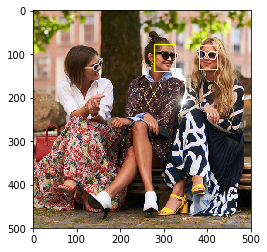

[{'box': [277, 78, 48, 61],
  'confidence': 0.9972823858261108,
  'keypoints': {'left_eye': (302, 99),
   'mouth_left': (298, 122),
   'mouth_right': (317, 124),
   'nose': (316, 112),
   'right_eye': (321, 102)}},
 {'box': [382, 80, 41, 54],
  'confidence': 0.994125247001648,
  'keypoints': {'left_eye': (389, 101),
   'mouth_left': (390, 121),
   'mouth_right': (407, 121),
   'nose': (397, 112),
   'right_eye': (409, 101)}}]

In [107]:
result = extract_faces(imgs[1])
result

In [0]:
def crop_faces(img, mtcnn_result):
  temp_faces = []
  
  img_height = img.shape[0]
  img_width=  img.shape[1]
  count_idx = 0
  for result in mtcnn_result:
    if(result['confidence'] > 0.5):
      left, top, width, height = map(int,result['box'])
      right = left+width
      bottom = top+height
      #print('>',width, height, left, top, right, bottom)
      
      
      # Make the bounding box a square
      width = min(width, height)
      height = width
      
      left=int(max(0, left-0.8*width))
      top=int(max(0, top-0.8*height))
  
      # Resize bounding box to get hair and ears inside it
      width = int(min(img_width, width*2.3))
      height = int(min(img_height, height*2.3))
      
      bottom = top+height
      right = left+width
      
      #print('>>',width, height, left, top, right, bottom)
  
      
      # Make sure that bounding box does not exceed image boundary
      overshoot_x = right - img_width
      overshoot_y = bottom - img_height
      if overshoot_x > 0:  # if bounding box exceeds image's right bound
        left = left-overshoot_x
  
      if overshoot_y > 0:  # if bounding box exceeds image's right bound
        top = top-overshoot_y
        
      if left<0:
        top = top-left
        left = 0
      if top<0:
        left = left-top
        top=0
        
      width = right-left
      height = bottom-top
      
      width = min(width, height)
      height = min(width, height)
      
      bottom = top+height
      right = left+width
        
        
      #print(width, height)
      tmp_img = img[top:bottom,left:right]
      if tmp_img.shape[0]:
        tmp_img = cv2.resize(tmp_img,(100,100))
      else:
        tmp_img=np.zeros((100,100,3))


      tmp_img=tmp_img/255

      if tmp_img.shape[2]==4:
        temp_faces.append(np.asarray(tmp_img[:,:,:3]))
      else:
        temp_faces.append(np.asarray(tmp_img))

    count_idx+=1
    
  return np.asarray(temp_faces)

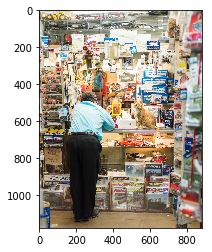

[{'box': [391, 500, 47, 63],
  'confidence': 0.9956026077270508,
  'keypoints': {'left_eye': (401, 525),
   'mouth_left': (405, 549),
   'mouth_right': (423, 548),
   'nose': (411, 542),
   'right_eye': (423, 524)}}]

In [109]:
extract_faces(imgs[8])

In [0]:
def predict_faces(img):
  result = extract_faces(img)
  cropped_faces = crop_faces(img, result)
  if len(cropped_faces) == 0:
    print("No faces found")
  else:
    for i in range(len(cropped_faces)):
      left, top, width, height = map(int,result[i]['box'])
      right = left+width
      bottom = top+height
      coord = {
          'left':left,
          'top':top,
          'bottom':bottom,
          'right':right
      }
      pred_em = emotion_model.predict(np.asarray([cropped_faces[i]]))
      pred_eth = ethinicity_model.predict(np.asarray([cropped_faces[i]]))
      pred_age = age_model.predict(np.asarray([cropped_faces[i]]))
      print('Face {0}:'.format(i))
      print('Coordinates:',str(coord))
      print('Emotion:'+emotion_list[np.argmax(pred_em)])
      print('Age:'+age_list[np.argmax(pred_age)])
      print('Ethnicity:'+e_list[np.argmax(pred_eth)])
      
      #print('Face Coordinates: '+str(coord)+', Class '+emotion_list[np.argmax(pred)]+': Confidence '+max(pred))
  

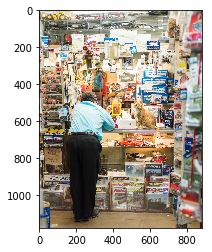

Face 0:
Coordinates: {'left': 391, 'top': 500, 'bottom': 563, 'right': 438}
Emotion:Happy
Age:30_40
Ethnicity:White


In [111]:
predict_faces(imgs[8])